In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
ndvi_data_path = '/content/drive/MyDrive/DEPI/Processed_Data/NDVI'

In [8]:
# %pip install sklearn

In [9]:
os.listdir(ndvi_data_path)

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'SeaLake',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River']

In [10]:
# import os
# import numpy as np

# bad_files = []

# for root, _, files in os.walk(ndvi_data_path):
#     for f in files:
#         if f.endswith(".npy"):
#             file_path = os.path.join(root, f)
#             try:
#                 np.load(file_path)
#             except:
#                 bad_files.append(file_path)

# print("Corrupted files:")
# for bf in bad_files:
#     print(bf)


In [11]:
data_dir = ndvi_data_path

classes = sorted(os.listdir(data_dir))
print("Found classes:", classes)

X = []
y = []

for idx, cls in enumerate(classes):
    cls_folder = os.path.join(data_dir, cls)

    for file in os.listdir(cls_folder):
        if file.endswith('.npy'):
            file_path = os.path.join(cls_folder, file)

            try:
                arr = np.load(file_path)

                if arr.size == 0:
                    print("Empty file skipped:", file_path)
                    continue

                if len(arr.shape) == 2:
                    arr = arr[..., np.newaxis]

                X.append(arr)
                y.append(idx)

            except Exception as e:
                print(f"Skipped corrupted file: {file_path} — {e}")
                continue

X = np.array(X)
y = np.array(y)

print(f"Loaded {len(X)} samples with shape {X.shape}")


Found classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Skipped corrupted file: /content/drive/MyDrive/DEPI/Processed_Data/NDVI/Forest/Forest_716.npy — No data left in file
Loaded 24792 samples with shape (24792, 64, 64, 1)


In [12]:
num_classes = len(classes)
y_cat = to_categorical(y, num_classes)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")



Training samples: 19833, Validation samples: 4959


In [13]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [25]:
input_shape = X_train.shape[1:]

model_ndvi = Sequential([
    Conv2D(32, (3, 3), input_shape=input_shape, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),


    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


model_ndvi.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_ndvi.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,472,778 (5.62 MB)

 Trainable params: 1,471,818 (5.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [26]:
history = model_ndvi.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.5396 - loss: 1.6255 - val_accuracy: 0.7249 - val_loss: 0.8232
Epoch 2/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7401 - loss: 0.8325 - val_accuracy: 0.5463 - val_loss: 2.4126
Epoch 3/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7880 - loss: 0.6540 - val_accuracy: 0.7768 - val_loss: 0.6494
Epoch 4/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8171 - loss: 0.5654 - val_accuracy: 0.8703 - val_loss: 0.4226
Epoch 5/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8320 - loss: 0.5158 - val_accuracy: 0.6810 - val_loss: 1.1935
Epoch 6/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8548 - loss: 0.4473 - val_accuracy: 0.7120 - val_loss: 0.8307
Epoch 7/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8650 - loss: 0.4036 - val_accuracy: 0.7647 - val_loss: 0.6942
Epoch 8/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8713 - loss: 0.3945 - val_accuracy: 

In [27]:
print("\nEvaluating the model:")
loss, accuracy = model_ndvi.evaluate(X_val, y_val, batch_size=24)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


Evaluating the model:
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8725 - loss: 0.4073
Validation Loss: 0.4226
Validation Accuracy: 0.8703


155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


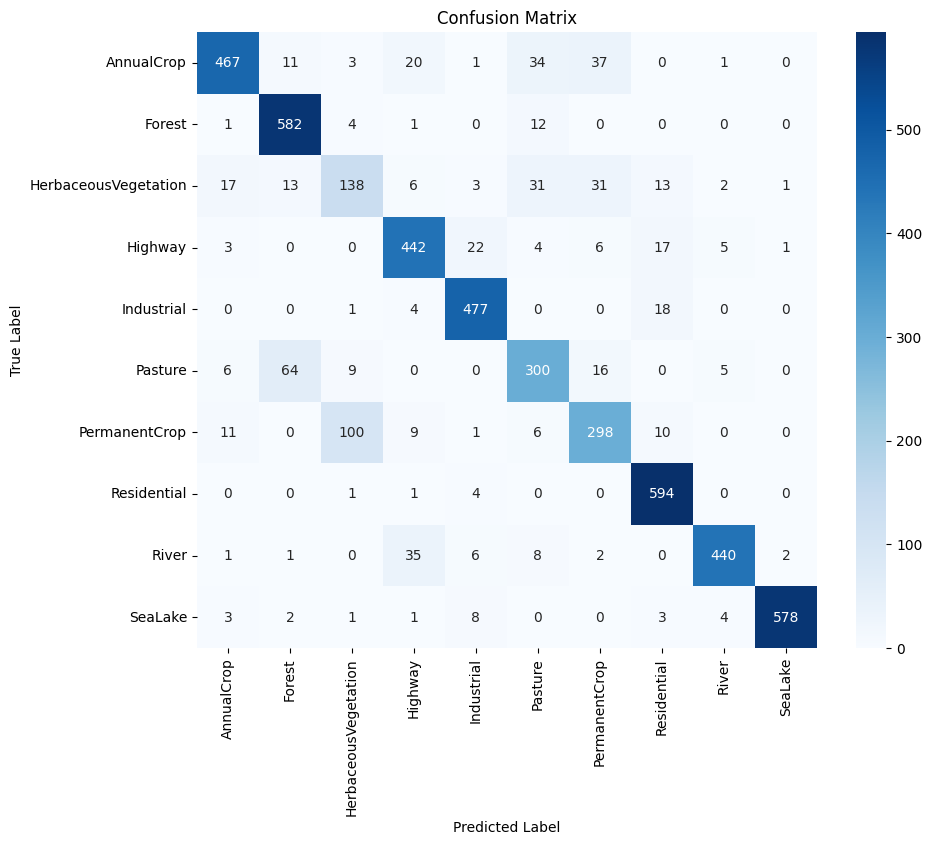

In [28]:
y_pred_proba = model_ndvi.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [29]:
model_ndvi = Sequential([
    Conv2D(32, (3, 3), input_shape=(64, 64, 1), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model_ndvi.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_ndvi.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)              │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 2, 2, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 512)            │             

 Total params: 2,328,586 (8.88 MB)

 Trainable params: 2,326,090 (8.87 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [30]:
history = model_ndvi.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.6022 - loss: 1.3077 - val_accuracy: 0.4856 - val_loss: 1.5067
Epoch 2/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7658 - loss: 0.7158 - val_accuracy: 0.5178 - val_loss: 1.3681
Epoch 3/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8089 - loss: 0.5903 - val_accuracy: 0.5479 - val_loss: 2.1334
Epoch 4/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8354 - loss: 0.5178 - val_accuracy: 0.7606 - val_loss: 0.7549
Epoch 5/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8522 - loss: 0.4693 - val_accuracy: 0.7497 - val_loss: 0.7393
Epoch 6/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8705 - loss: 0.4123 - val_accuracy: 0.7465 - val_loss: 0.7434
Epoch 7/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8829 - loss: 0.3810 - val_accuracy: 0.5076 - val_loss: 1.9768
Epoch 8/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8809 - loss: 0.3739 - val_acc

In [31]:
print("\nEvaluating the model:")
loss, accuracy = model_ndvi.evaluate(X_val, y_val, batch_size=24)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")



Evaluating the model:
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9030 - loss: 0.3193
Validation Loss: 0.3512
Validation Accuracy: 0.8951


In [32]:
model_ndvi.save('model_NDVI_v0.h5')

155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


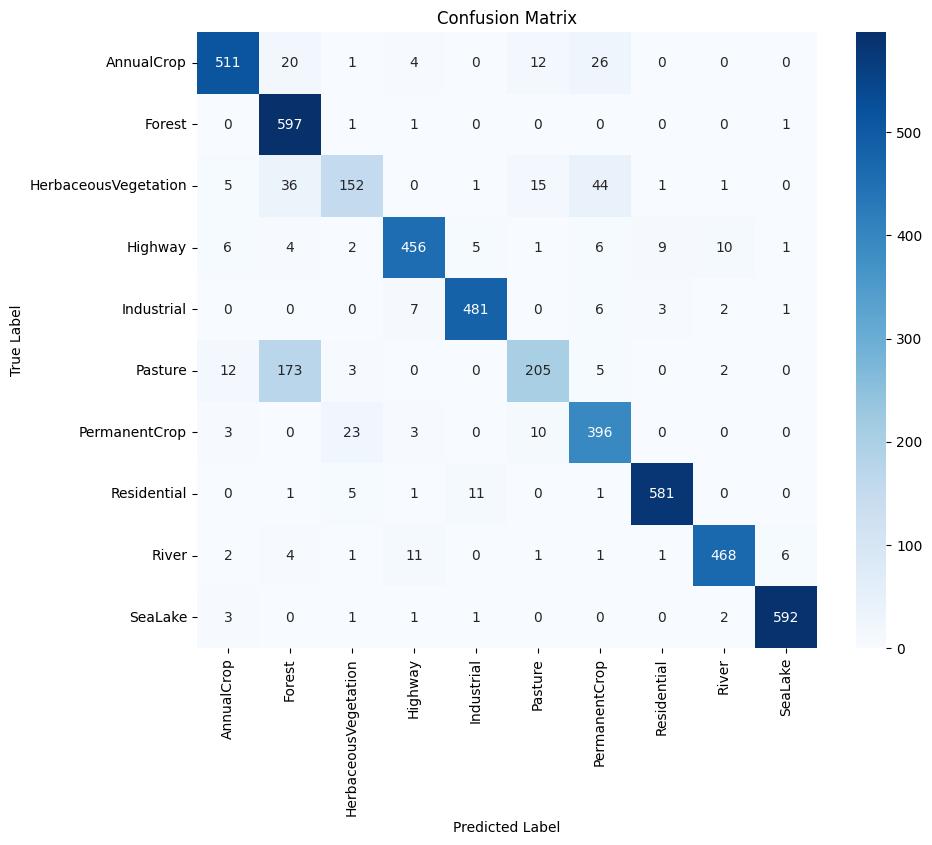

In [33]:
y_pred_proba = model_ndvi.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [34]:
model_ndvi = Sequential([
    Conv2D(32, (3, 3), input_shape=(64, 64, 1), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, (3, 3), activation='relu', padding='same'), # Added layer
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    # Removed one MaxPooling2D here

    Conv2D(1024, (3, 3), activation='relu', padding='same'), # Added layer
    BatchNormalization(),
    # Removed another MaxPooling2D here

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])
model_ndvi.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
history = model_ndvi.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.6379 - loss: 1.2675 - val_accuracy: 0.2474 - val_loss: 6.0608
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7785 - loss: 0.6847 - val_accuracy: 0.6955 - val_loss: 1.3401
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8299 - loss: 0.5294 - val_accuracy: 0.6669 - val_loss: 1.5156
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8504 - loss: 0.4928 - val_accuracy: 0.6703 - val_loss: 1.2554
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8670 - loss: 0.4179 - val_accuracy: 0.8169 - val_loss: 0.5883
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8887 - loss: 0.3491 - val_accuracy: 0.7643 - val_loss: 0.5835
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9016 - loss: 0.3132 - val_accuracy: 0.1367 - val_loss: 11.1523
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.7877 - loss: 0.6457 - val_a

In [36]:
%pip install matplotlib

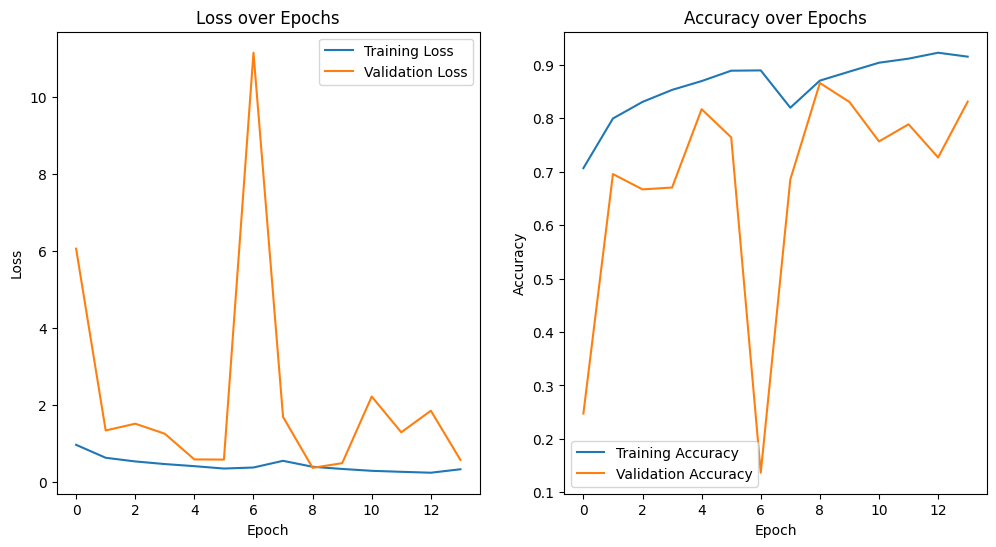

In [37]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [38]:
model_ndvi.save('model_NDVI_v1.h5')

155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


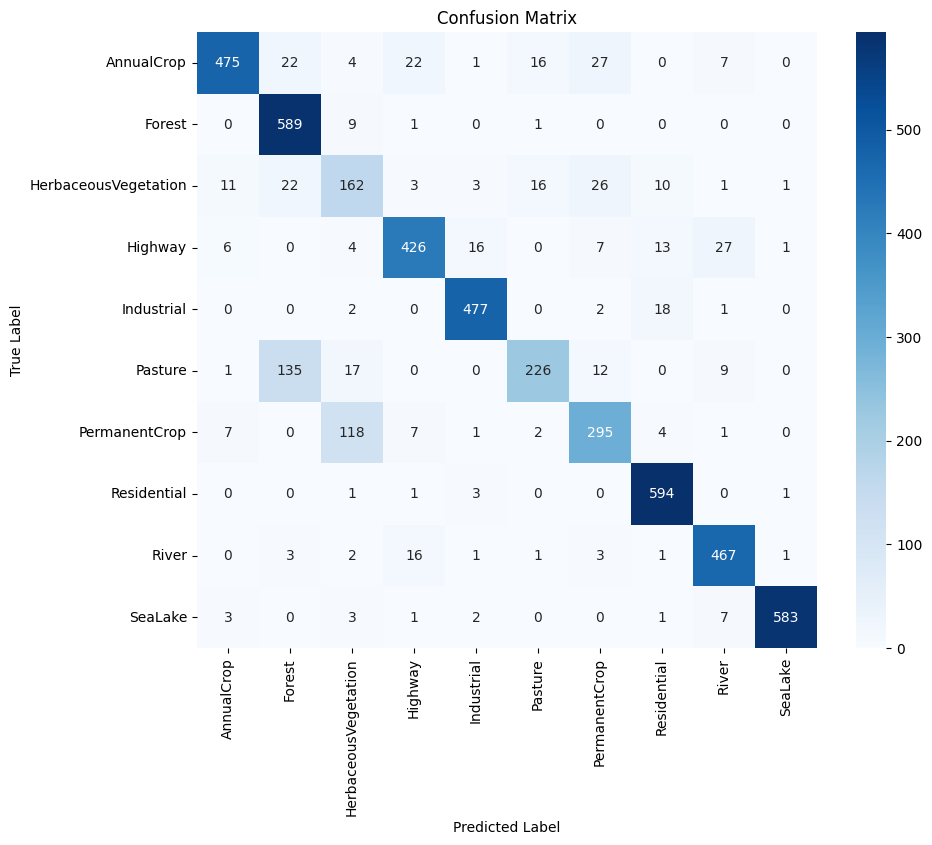

In [39]:
y_pred_proba = model_ndvi.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [40]:
model_ndvi = Sequential([
    Conv2D(32, (3, 3), input_shape=(64, 64, 1), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
model_ndvi.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
history = model_ndvi.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.5385 - loss: 1.6947 - val_accuracy: 0.6927 - val_loss: 0.9212
Epoch 2/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7371 - loss: 0.8131 - val_accuracy: 0.6925 - val_loss: 0.7435
Epoch 3/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7693 - loss: 0.7432 - val_accuracy: 0.6790 - val_loss: 0.8306
Epoch 4/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8100 - loss: 0.6100 - val_accuracy: 0.8145 - val_loss: 0.6018
Epoch 5/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8321 - loss: 0.5493 - val_accuracy: 0.7493 - val_loss: 0.7794
Epoch 6/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8513 - loss: 0.4836 - val_accuracy: 0.7405 - val_loss: 0.8322
Epoch 7/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.8596 - loss: 0.4363 - val_accuracy: 0.8221 - val_loss: 0.5458
Epoch 8/50
620/620 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8655 - loss: 0.4453 - 

In [43]:
print("\nEvaluating the model:")
loss, accuracy = model_ndvi.evaluate(X_val, y_val, batch_size=24)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


Evaluating the model:
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8813 - loss: 0.3368
Validation Loss: 0.3555
Validation Accuracy: 0.8812


155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


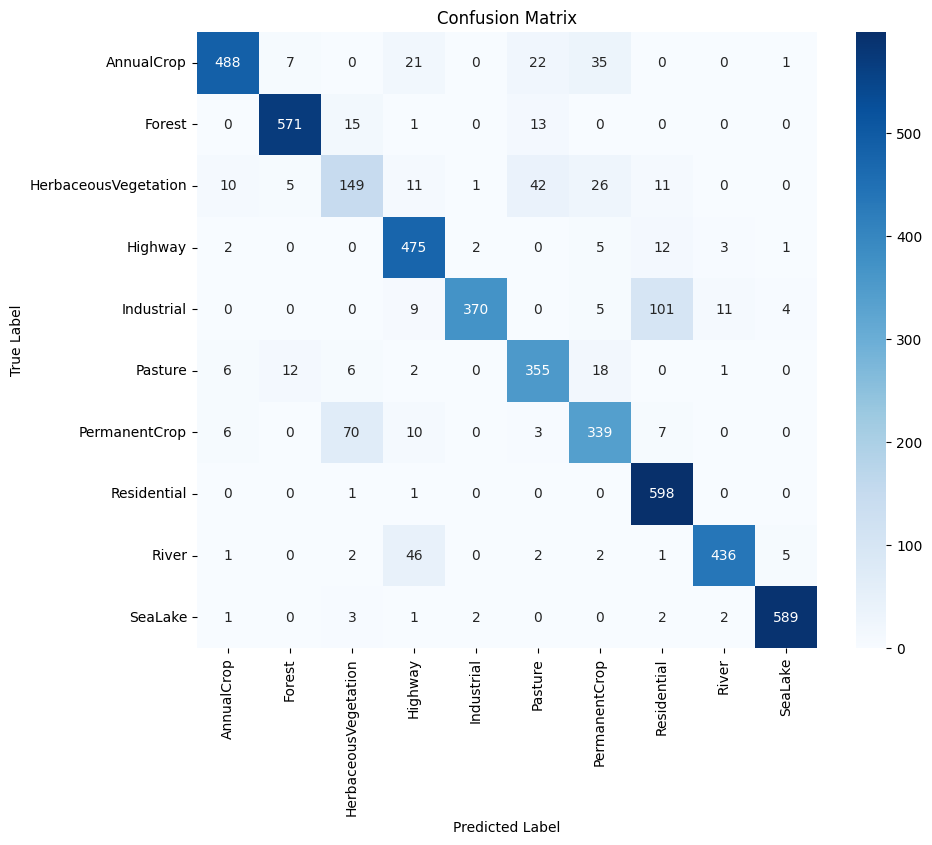

In [44]:
y_pred_proba = model_ndvi.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [45]:
model_ndvi.save('model_NDVI_v2.h5')